<a href="https://colab.research.google.com/github/AnushaNatesan/Machine-Learning-Lab/blob/main/Linear-Regression/Linear_Regression_ML_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import the necessary libraries**

In [77]:
# STEP 1: Install kagglehub (if needed)
!pip install kagglehub --quiet

In [78]:
# STEP 2: Import required libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import kagglehub

In [79]:
# STEP 3: Download and Load Dataset
path = kagglehub.dataset_download("phileinsophos/predict-loan-amount-data")
print("Files downloaded:", os.listdir(path))

train_df = pd.read_csv(os.path.join(path, "train.csv"))
test_df = pd.read_csv(os.path.join(path, "test.csv"))

Files downloaded: ['train.csv', 'test.csv']


In [80]:
# STEP 4: Clean Columns, Drop IDs, Handle Missing
train_df.columns = train_df.columns.str.strip().str.replace(" ", "_").str.replace("(", "", regex=False).str.replace(")", "", regex=False)
test_df.columns = test_df.columns.str.strip().str.replace(" ", "_").str.replace("(", "", regex=False).str.replace(")", "", regex=False)

# Drop unnecessary columns
train_df.drop(columns=['Customer_ID', 'Name', 'Property_ID'], inplace=True, errors='ignore')
test_df.drop(columns=['Customer_ID', 'Name', 'Property_ID'], inplace=True, errors='ignore')

# Define target column
target_col = 'Loan_Sanction_Amount_USD'

# Replace '?' with NaN before filling missing values
train_df.replace('?', np.nan, inplace=True)
test_df.replace('?', np.nan, inplace=True)

# Fill missing values
for col in train_df.columns:
    if train_df[col].dtype == 'object':
        train_df[col].fillna(train_df[col].mode()[0], inplace=True)
    else:
        train_df[col].fillna(train_df[col].mean(), inplace=True)

for col in test_df.columns:
    if test_df[col].dtype == 'object':
        test_df[col].fillna(train_df[col].mode()[0], inplace=True)
    else:
        test_df[col].fillna(train_df[col].mean(), inplace=True)

/tmp/ipython-input-80-452152434.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna(train_df[col].mode()[0], inplace=True)
/tmp/ipython-input-80-452152434.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpla

In [81]:
# STEP 5: Encode Categorical Columns using same LabelEncoders
label_encoders = {}
# Identify categorical columns again after filling missing values
cat_cols = train_df.select_dtypes(include='object').columns

for col in cat_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])

    # Replace unseen labels in test data with '<UNK>'
    test_df[col] = test_df[col].apply(lambda x: x if x in le.classes_ else '<UNK>')
    le.classes_ = np.append(le.classes_, '<UNK>')
    test_df[col] = le.transform(test_df[col])

    label_encoders[col] = le

# Ensure all columns are numeric before scaling
for col in train_df.columns:
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce')
for col in test_df.columns:
    test_df[col] = pd.to_numeric(test_df[col], errors='coerce')

# Fill any NaNs introduced by coercion (if any)
train_df.fillna(train_df.mean(), inplace=True)
test_df.fillna(test_df.mean(), inplace=True)

In [82]:
# STEP 6: Feature Scaling and Split
X = train_df.drop(target_col, axis=1)
y = train_df[target_col]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [83]:
# STEP 7: Train and Evaluate Model
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print("Model Evaluation on Validation Set:")
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r2)

Model Evaluation on Validation Set:
MAE: 21707.34894824274
MSE: 981775294.9074459
RMSE: 31333.29371303703
R2 Score: 0.572943185067988


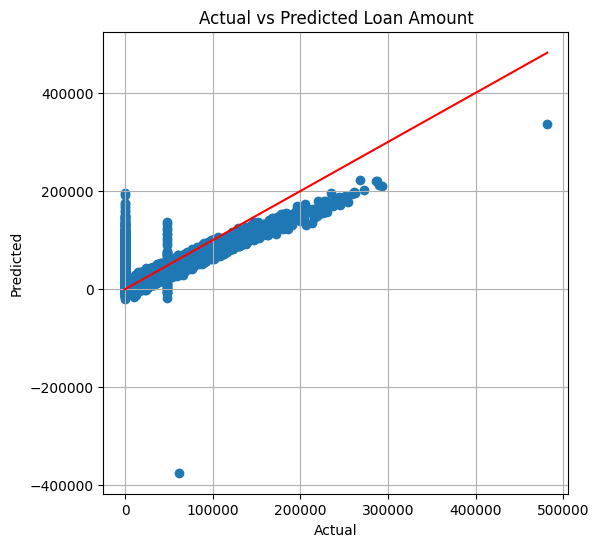

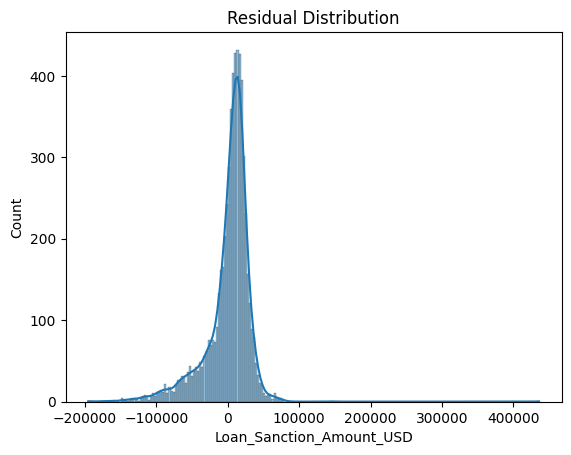

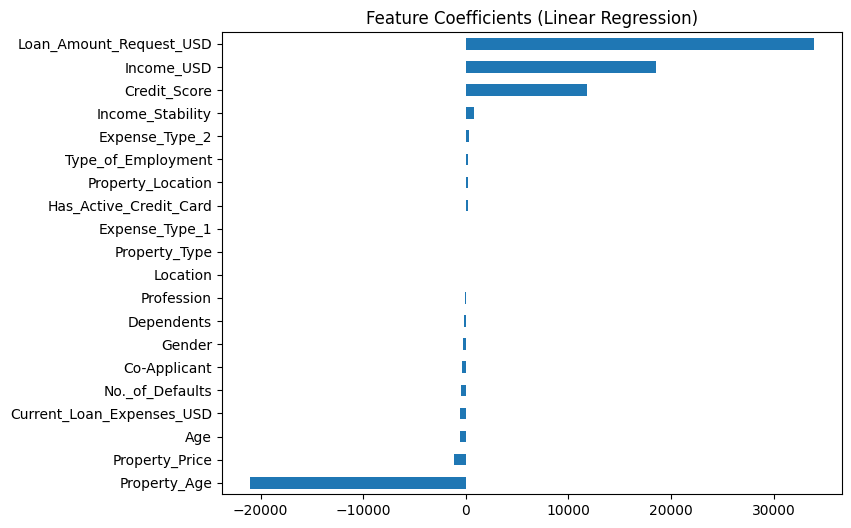

In [84]:
# STEP 8: Visualizations
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Loan Amount")
plt.grid(True)
plt.show()

residuals = y_val - y_pred
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.show()

coef_df = pd.Series(model.coef_, index=X.columns)
coef_df.sort_values().plot(kind='barh', figsize=(8, 6))
plt.title("Feature Coefficients (Linear Regression)")
plt.show()

In [85]:
# STEP 9: Cross-Validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

mae_cv = -cross_val_score(model, X_scaled, y, scoring='neg_mean_absolute_error', cv=cv)
mse_cv = -cross_val_score(model, X_scaled, y, scoring='neg_mean_squared_error', cv=cv)
r2_cv = cross_val_score(model, X_scaled, y, scoring='r2', cv=cv)

print("\nCross-Validation Scores:")
for i in range(5):
    print(f"Fold {i+1}: MAE={mae_cv[i]:.2f}, MSE={mse_cv[i]:.2f}, R2={r2_cv[i]:.2f}")

print("\nAverage MAE:", mae_cv.mean())
print("Average MSE:", mse_cv.mean())
print("Average R2:", r2_cv.mean())


Cross-Validation Scores:
Fold 1: MAE=21707.35, MSE=981775294.91, R2=0.57
Fold 2: MAE=21872.18, MSE=979577829.23, R2=0.57
Fold 3: MAE=22364.06, MSE=1064344947.87, R2=0.54
Fold 4: MAE=21752.63, MSE=992875407.17, R2=0.58
Fold 5: MAE=21005.40, MSE=879901819.13, R2=0.61

Average MAE: 21740.323013950943
Average MSE: 979695059.6602628
Average R2: 0.5739754495958775


In [86]:
# STEP 10: Predict on Test Set
X_test = test_df[X.columns]  # same order
X_test_scaled = scaler.transform(X_test)

test_predictions = model.predict(X_test_scaled)
test_df['Predicted_Loan_Amount'] = test_predictions
test_df[['Predicted_Loan_Amount']].to_csv("loan_predictions.csv", index=False)

print("\n✅ Predictions saved to loan_predictions.csv")


✅ Predictions saved to loan_predictions.csv
